In [ ]:
!pip install torchsummary
!pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST, CIFAR100
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_data = FashionMNIST('data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = FashionMNIST('data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class Control(nn.Module):
    def __init__(self):
        super(Control, self).__init__()

        self.conv1A = nn.Conv2d(1, 100, 3, 1, 1, bias=True)
        self.conv1B = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv1C = nn.Conv2d(100, 100, 2, 2, 0, bias=False) # 14x14
        self.conv2A = nn.Conv2d(100, 200, 3, 1, 1, bias=True)
        self.conv2B = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv2C = nn.Conv2d(200, 200, 2, 2, 0, bias=False) # 7x7
        self.neuron_out = nn.Linear(7*7*200, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        x = self.LRelu(x)
        x = self.conv1B(x)
        x = self.LRelu(x)
        x = self.conv1C(x)
        x = self.LRelu(x)

        x = self.conv2A(x)
        x = self.LRelu(x)
        x = self.conv2B(x)
        x = self.LRelu(x)
        x = self.conv2C(x)
        x = self.LRelu(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        return output

In [ ]:
control_model = Control().to(device)

In [ ]:
summary(control_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 28, 28]           1,000
         LeakyReLU-2          [-1, 100, 28, 28]               0
            Conv2d-3          [-1, 100, 28, 28]          90,100
         LeakyReLU-4          [-1, 100, 28, 28]               0
            Conv2d-5          [-1, 100, 14, 14]          40,000
         LeakyReLU-6          [-1, 100, 14, 14]               0
            Conv2d-7          [-1, 200, 14, 14]         180,200
         LeakyReLU-8          [-1, 200, 14, 14]               0
            Conv2d-9          [-1, 200, 14, 14]         360,200
        LeakyReLU-10          [-1, 200, 14, 14]               0
           Conv2d-11            [-1, 200, 7, 7]         160,000
        LeakyReLU-12            [-1, 200, 7, 7]               0
           Linear-13                   [-1, 10]          98,010
Total params: 929,510
Trainable params:

In [ ]:
class HeadAttention(torch.nn.Module):

    '''
    Attention Layer might be useful to detect most relevant features in the images.

    Adapted in order to be used with element-wise operations directly to images and feature maps.

    There are weights for the rows(X axis) and for the columns(Y axis). Each weight is applied to the input first in the X axis and then in the Y axis.

    At the end, the result is multiplied in order to get the proper array of weights, where aij = weight map

    So each attention weight is something like this:

      |Aij Bij Cij|
      |Dij Eij Fij|, where Xij = weight x axis * weight y axis
      |Gij Hij Iij|

    Considering that the softmax function has outputs within range [0,1], we can conclude that each weight will be within range [0,1], where 1 is the most important feature.

    OBS: This layer generates small gradients. When stacking too many layers, consider adding residual blocks and skip connections.
    '''

    def __init__(self, input_channels, input_height, input_width):

        super(HeadAttention, self).__init__()

        # Creating array of weights for element-wise operations
        self.x_weights = torch.normal(0, 0.02, size=(input_channels, input_height, input_width), device=device, requires_grad=True)
        self.y_weights = torch.normal(0, 0.02, size=(input_channels, input_height, input_width), device=device, requires_grad=True)

        # Alternative: Create weights with size (channels, height, widt) and multiply over each batch.

        self.batchnorm = torch.nn.BatchNorm2d(input_channels) # To compensate the sqrt(d_key) scaling factor

        #self.softmax = torch.nn.Softmax2d() # Computes softmax over each channel
        self.Xsoftmax = torch.nn.Softmax(-2)
        self.Ysoftmax = torch.nn.Softmax(-1)

    def forward(self, input):

        attention_output = []

        for batch in range(input.size(0)):

            input_data = input[batch] # (Channels, Height, Width)

            x_weights = input_data * self.x_weights
            y_weights = input_data * self.y_weights

            x_weights = self.Xsoftmax(x_weights)
            y_weights = self.Ysoftmax(y_weights)

            attention_weights = x_weights * y_weights # (Channels, Height, Width)

            attention_output.append(attention_weights.unsqueeze(0)) # (1, Channels, Height, Width)

        attention_output = torch.cat(attention_output, 0) # (Batch, Channels, Height, Width)

        attention_output = input * attention_weights # (Batch, Channels, Height, Width)

        return attention_output

Parâmetros de Controle = 929,510
Parâmetros de Attention Model = 1,568 por attention layer+8000 linear ---> 2 layers e 8 cabeças + linear = 33,088 parâmetros

Quanto mais se adiciona layers ao Attention Model ---> Maior tendência de vanishing gradients

Optimizers padrão: Adam com Learning Rate = 1e-3

**Loss Controle = 11.24**

**Accuracy Controle = 85%**

### **2 Attention layers com 8 cabeças:**

Loss Attention = 24

Accuracy Attention = 75%

**USANDO LEARNING RATE = 0.1**

Loss Attention = 8.33

Accuracy Attention = 80.6%

### **2 Attention layers com 16 cabeças:**

Loss Attention = 17.21

Accuracy Attention = 71%

**USANDO LEARNING RATE = 0.1**

Loss Attention = 7.01

Accuracy Attention = 82.5%

### **4 Attention layers com 8 cabeças:**

Loss Attention = 18.10

Accuracy Attention = 72.65%

**USANDO LEARNING RATE = 0.1**

Loss Attention = 8.02

Accuracy Attention = 80,5%

### **4 Attention Layers com 16 cabeças:**

Loss Attention = 15.55

Accuracy Attention = 72%

Média de gradientes similar à com 8 cabeças

**USANDO LEARNING RATE = 0.1**

Loss Attention = 6.63

Accuracy Attention = 83,81%

Possíveis vantagens: Menor tempo de treinamento(menos parâmetros) e possibilidade de desempenho similar a Conv2D padrão.

In [ ]:
class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.n_heads = n_heads

        self.attention1 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention1 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm1 = nn.BatchNorm2d(1)
        self.attention2 = torch.nn.ModuleList([HeadAttention(1, 28, 28) for i in range(n_heads)])
        self.convattention2 = nn.Conv2d(1*n_heads, 1, 3, 1, 1, bias=True)
        self.batchnorm2 = nn.BatchNorm2d(1)
        self.neuron_out = nn.Linear(1*28*28, 10, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention1[head](input)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention1(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = input + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm1(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention2[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention2(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm2(attention_output)

        x = self.LRelu(attention_output)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output

In [ ]:
attention_model = AttentionModel(8).to(device)

In [ ]:
summary(attention_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Softmax-1               [-1, 28, 28]               0
           Softmax-2               [-1, 28, 28]               0
           Softmax-3               [-1, 28, 28]               0
           Softmax-4               [-1, 28, 28]               0
     HeadAttention-5            [-1, 1, 28, 28]               0
           Softmax-6               [-1, 28, 28]               0
           Softmax-7               [-1, 28, 28]               0
           Softmax-8               [-1, 28, 28]               0
           Softmax-9               [-1, 28, 28]               0
    HeadAttention-10            [-1, 1, 28, 28]               0
          Softmax-11               [-1, 28, 28]               0
          Softmax-12               [-1, 28, 28]               0
          Softmax-13               [-1, 28, 28]               0
          Softmax-14               [-1,

In [ ]:
def weights_init(net):

    for n, p in net.named_parameters():

        if 'weight' in n:

            nn.init.normal_(p, 0, 0.02)

        else:

            nn.init.constant_(p, 0.)

In [ ]:
weights_init(control_model)
weights_init(attention_model)

In [ ]:
optimizer_control = torch.optim.Adam(control_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)

control_losses = []
control_accuracies = []
attention_losses = []
attention_accuracies = []

control_gradients = []
attention_gradients = []

In [ ]:
for epoch in range(EPOCHS):

    control_epoch_loss = 0.
    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        control_model.zero_grad()
        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        control_output = control_model(image)
        attention_output = attention_model(image)

        control_loss = loss(control_output, target)

        control_losses.append(control_loss.item())

        control_epoch_loss += control_loss.item()

        control_loss.backward()

        control_gradients_avg = torch.mean(control_model.conv1A.weight.grad)
        control_gradients.append(control_gradients_avg.cpu())

        optimizer_control.step()

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_control = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                control_output = control_model(image)
                attention_output = attention_model(image)

            total += len(target)

            _, control_output = torch.max(control_output, 1)
            _, attention_output = torch.max(attention_output, 1)
            
            correct_control += (control_output == target).sum()
            correct_attention += (attention_output == target).sum()


        control_accuracy = (correct_control/total)*100
        control_accuracies.append(control_accuracy.cpu())

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Control Model Loss: {control_epoch_loss}\tControl Model Accuracy: {control_accuracy}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Control Gradients: {control_gradients[-1]}\tAttention Gradients: {attention_gradients[-1]}")


1/10
Control Model Loss: 22.171854257583618	Control Model Accuracy: 68.77999877929688
Attention Model Loss: 33.9911892414093	Attention Model Accuracy: 36.869998931884766
Control Gradients: 0.0024587763473391533	Attention Gradients: -4.407650078253056e-10
2/10
Control Model Loss: 10.685013890266418	Control Model Accuracy: 77.45999908447266
Attention Model Loss: 31.436212062835693	Attention Model Accuracy: 52.82999801635742
Control Gradients: 0.0016463615465909243	Attention Gradients: 6.950395259330833e-10
3/10
Control Model Loss: 8.094592034816742	Control Model Accuracy: 81.5999984741211
Attention Model Loss: 26.97327435016632	Attention Model Accuracy: 62.38999938964844
Control Gradients: -5.516512828762643e-05	Attention Gradients: 5.5331764059474153e-08
4/10
Control Model Loss: 6.806724667549133	Control Model Accuracy: 83.7300033569336
Attention Model Loss: 21.724695324897766	Attention Model Accuracy: 66.04999542236328
Control Gradients: 0.0010411028051748872	Attention Gradients: 1.493

Text(0.5, 1.0, 'Attention Gradients Average')

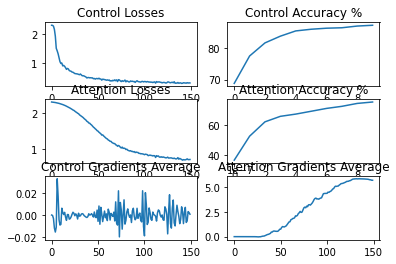

In [ ]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

In [ ]:
# Treinando apenas o Attention Model, com LR = 0.1

weights_init(attention_model)

EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=True)
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-1, betas=(0.9, 0.999))
attention_losses = []
attention_accuracies = []

attention_gradients = []

In [ ]:
# Treinando apenas o Attention Model

for epoch in range(EPOCHS):

    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        attention_output = attention_model(image)

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                attention_output = attention_model(image)

            total += len(target)

            _, attention_output = torch.max(attention_output, 1)
            
            correct_attention += (attention_output == target).sum()

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Attention Gradients: {attention_gradients[-1]}")

1/10
Attention Model Loss: 22.643056631088257	Attention Model Accuracy: 64.20999908447266
Attention Gradients: -2.3107152173906798e-06
2/10
Attention Model Loss: 11.585766613483429	Attention Model Accuracy: 75.72999572753906
Attention Gradients: -2.86499084722891e-06
3/10
Attention Model Loss: 9.38756912946701	Attention Model Accuracy: 78.88999938964844
Attention Gradients: -9.891105037240777e-06
4/10
Attention Model Loss: 8.30634617805481	Attention Model Accuracy: 80.90999603271484
Attention Gradients: -1.2628229342226405e-05
5/10
Attention Model Loss: 7.708890944719315	Attention Model Accuracy: 82.05999755859375
Attention Gradients: -9.402959221915808e-06
6/10
Attention Model Loss: 7.403263300657272	Attention Model Accuracy: 81.05999755859375
Attention Gradients: -1.1513357094372623e-05
7/10
Attention Model Loss: 7.271772682666779	Attention Model Accuracy: 82.1500015258789
Attention Gradients: -1.1721207556547597e-05
8/10
Attention Model Loss: 7.035130560398102	Attention Model Accura

Text(0.5, 1.0, 'Attention Gradients Average')

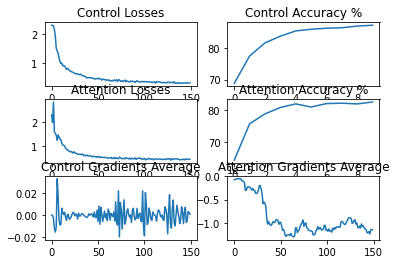

In [ ]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")

In [ ]:
from torch.utils import tensorboard

writer = tensorboard.SummaryWriter(log_dir='Test')

writer.add_graph(control_model, torch.randn((1, 1, 28, 28), device=device))
writer.add_graph(attention_model, torch.randn((1, 1, 28, 28), device=device))

writer.add_scalar("Control Losses", control_losses)
writer.add_scalar("Attention Losses", attention_losses)
writer.add_scalar("Control Accuracy", control_accuracies)
writer.add_scalar("Attention Accuracy", attention_accuracies)
writer.add_scalar("Control Gradients Average", control_gradients)
writer.add_scalar("Attention Gradients Average", attention_gradients)

writer.close()

# Testing with CIFAR100

In [ ]:
cifar_train = CIFAR100('data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
cifar_test = CIFAR100('data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [ ]:
class Control(nn.Module):
    def __init__(self):
        super(Control, self).__init__()

        self.conv1A = nn.Conv2d(3, 100, 3, 1, 1, bias=True) # 32x32
        self.conv1B = nn.Conv2d(100, 100, 3, 1, 1, bias=True)
        self.conv1C = nn.Conv2d(100, 100, 2, 2, 0, bias=False) # 16x16
        self.conv2A = nn.Conv2d(100, 200, 3, 1, 1, bias=True)
        self.conv2B = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv2C = nn.Conv2d(200, 200, 2, 2, 0, bias=False) # 8x8
        self.neuron_out = nn.Linear(8*8*200, 100, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version)

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        x = self.LRelu(x)
        x = self.conv1B(x)
        x = self.LRelu(x)
        x = self.conv1C(x)
        x = self.LRelu(x)

        x = self.conv2A(x)
        x = self.LRelu(x)
        x = self.conv2B(x)
        x = self.LRelu(x)
        x = self.conv2C(x)
        x = self.LRelu(x)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        return output

In [ ]:
control_model = Control().to(device)

In [ ]:
summary(control_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,800
         LeakyReLU-2          [-1, 100, 32, 32]               0
            Conv2d-3          [-1, 100, 32, 32]          90,100
         LeakyReLU-4          [-1, 100, 32, 32]               0
            Conv2d-5          [-1, 100, 16, 16]          40,000
         LeakyReLU-6          [-1, 100, 16, 16]               0
            Conv2d-7          [-1, 200, 16, 16]         180,200
         LeakyReLU-8          [-1, 200, 16, 16]               0
            Conv2d-9          [-1, 200, 16, 16]         360,200
        LeakyReLU-10          [-1, 200, 16, 16]               0
           Conv2d-11            [-1, 200, 8, 8]         160,000
        LeakyReLU-12            [-1, 200, 8, 8]               0
           Linear-13                  [-1, 100]       1,280,100
Total params: 2,113,400
Trainable param

In [ ]:
class AttentionModel(nn.Module):
    '''
    Attention Classifier
    '''
    def __init__(self, n_heads):
        super(AttentionModel, self).__init__()

        self.n_heads = n_heads

        self.attention1 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention1 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm1 = nn.BatchNorm2d(3)
        self.attention2 = torch.nn.ModuleList([HeadAttention(3, 32, 32) for i in range(n_heads)])
        self.convattention2 = nn.Conv2d(3*n_heads, 3, 3, 1, 1, bias=True)
        self.batchnorm2 = nn.BatchNorm2d(3)
        self.neuron_out = nn.Linear(3*32*32, 100, bias=True)

        #self.sigmoid = nn.Sigmoid() # ---> Included in BCEWithLogits (in log version) ---> Have to be used, since targets must be [0, 1]

        #self.pool2x2 = nn.AvgPool2d(2, 2)
        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention1[head](input)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention1(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = input + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm1(attention_output)

        x = self.LRelu(attention_output)

        residual_block = x

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention2[head](residual_block)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, 1) # (Batch, n_channels*n_heads, Height, Width)

        attention_output = self.convattention2(attention_output) # (Batch, n_channels, Height, Width)

        attention_output = residual_block + attention_output # (Batch, n_channels, Height, Width)

        attention_output = self.batchnorm2(attention_output)

        x = self.LRelu(attention_output)

        x = x.view(x.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output

In [ ]:
attention_model = AttentionModel(8).to(device)

In [ ]:
summary(attention_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Softmax-1               [-1, 32, 32]               0
           Softmax-2               [-1, 32, 32]               0
           Softmax-3               [-1, 32, 32]               0
           Softmax-4               [-1, 32, 32]               0
     HeadAttention-5            [-1, 3, 32, 32]               0
           Softmax-6               [-1, 32, 32]               0
           Softmax-7               [-1, 32, 32]               0
           Softmax-8               [-1, 32, 32]               0
           Softmax-9               [-1, 32, 32]               0
    HeadAttention-10            [-1, 3, 32, 32]               0
          Softmax-11               [-1, 32, 32]               0
          Softmax-12               [-1, 32, 32]               0
          Softmax-13               [-1, 32, 32]               0
          Softmax-14               [-1,

In [ ]:
weights_init(control_model)
weights_init(attention_model)

In [ ]:
optimizer_control = torch.optim.Adam(control_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer_attention = torch.optim.Adam(attention_model.parameters(), lr=1e-1, betas=(0.9, 0.999))

In [ ]:
EPOCHS = 10
iters = 0.

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1024, shuffle=True)

control_losses = []
control_accuracies = []
attention_losses = []
attention_accuracies = []

control_gradients = []
attention_gradients = []

Usar uma Learning Rate maior que 1e-3 no modelo de Controle impede a convergência do optimizer e gera losses altas e accuracy sempre 1.0

Com o Attention Model, uma Learning Rate maior simplesmente acelera a chegada do plateau de desempenho.

In [ ]:
for epoch in range(EPOCHS):

    control_epoch_loss = 0.
    attention_epoch_loss = 0.

    for item, (image, target) in enumerate(train_loader):

        control_model.zero_grad()
        attention_model.zero_grad()

        image, target = image.to(device), target.to(device)

        control_output = control_model(image)
        attention_output = attention_model(image)

        control_loss = loss(control_output, target)

        control_losses.append(control_loss.item())

        control_epoch_loss += control_loss.item()

        control_loss.backward()

        control_gradients_avg = torch.mean(control_model.conv1A.weight.grad)
        control_gradients.append(control_gradients_avg.cpu())

        optimizer_control.step()

        attention_loss = loss(attention_output, target)

        attention_losses.append(attention_loss.item())

        attention_epoch_loss += attention_loss.item()

        attention_loss.backward()

        attention_gradients_avg = torch.mean(attention_model.attention1[0].x_weights.grad)
        attention_gradients.append(attention_gradients_avg.cpu())

        optimizer_attention.step()

        iters += 1

    if epoch % 1 == 0:

        total = 0.
        correct_control = 0.
        correct_attention = 0.

        for item, (image, target) in enumerate(test_loader):

            image, target = image.to(device), target.to(device)

            with torch.no_grad():
                control_output = control_model(image)
                attention_output = attention_model(image)

            total += len(target)

            _, control_output = torch.max(control_output, 1)
            _, attention_output = torch.max(attention_output, 1)
            
            correct_control += (control_output == target).sum()
            correct_attention += (attention_output == target).sum()


        control_accuracy = (correct_control/total)*100
        control_accuracies.append(control_accuracy.cpu())

        attention_accuracy = (correct_attention/total)*100
        attention_accuracies.append(attention_accuracy.cpu())


        print(f"{epoch+1}/{EPOCHS}")
        print(f"Control Model Loss: {control_epoch_loss}\tControl Model Accuracy: {control_accuracy}")
        print(f"Attention Model Loss: {attention_epoch_loss}\tAttention Model Accuracy: {attention_accuracy}")
        print(f"Control Gradients: {control_gradients[-1]}\tAttention Gradients: {attention_gradients[-1]}")


1/10
Control Model Loss: 209.6954755783081	Control Model Accuracy: 11.949999809265137
Attention Model Loss: 655.969696521759	Attention Model Accuracy: 2.1700000762939453
Control Gradients: 0.02815781719982624	Attention Gradients: 1.2637995041586692e-06
2/10
Control Model Loss: 179.41056394577026	Control Model Accuracy: 17.200000762939453
Attention Model Loss: 241.41995000839233	Attention Model Accuracy: 5.809999942779541
Control Gradients: -0.005255809519439936	Attention Gradients: 1.4189923831509077e-06
3/10
Control Model Loss: 166.7461018562317	Control Model Accuracy: 22.239999771118164
Attention Model Loss: 208.0671410560608	Attention Model Accuracy: 9.34000015258789
Control Gradients: 0.039980027824640274	Attention Gradients: -1.9258632164564915e-06
4/10
Control Model Loss: 152.68222832679749	Control Model Accuracy: 26.059999465942383
Attention Model Loss: 198.20140767097473	Attention Model Accuracy: 10.710000038146973
Control Gradients: 0.008982634171843529	Attention Gradients: -2

Text(0.5, 1.0, 'Attention Gradients Average')

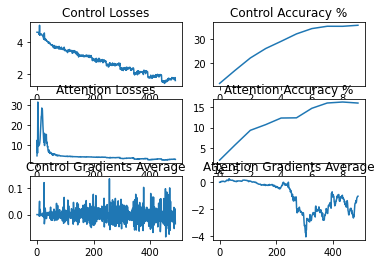

In [ ]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(torch.arange(0, iters), control_losses)
ax[0,0].set_title("Control Losses")
ax[1,0].plot(torch.arange(0, iters), attention_losses)
ax[1,0].set_title("Attention Losses")
ax[0,1].plot(torch.arange(0, EPOCHS), control_accuracies)
ax[0,1].set_title("Control Accuracy %")
ax[1,1].plot(torch.arange(0, EPOCHS), attention_accuracies)
ax[1,1].set_title("Attention Accuracy %")

ax[2,0].plot(torch.arange(0, iters), control_gradients)
ax[2,0].set_title("Control Gradients Average")
ax[2,1].plot(torch.arange(0, iters), attention_gradients)
ax[2,1].set_title("Attention Gradients Average")